In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [6]:
# Classification parameters and setup
time_window = 50
time_step = 25
n_splits = 1000
trial_averages = [20]
group_dict = {0:[1],1:[2],2:[3],3:[4]}
test = False # if true, test pipeline on only 3 subjects
experiment_names = ['1801','1901','1902']

In [15]:
# If you want to retrain classifiers, run this cell. Otherwise go to next cell.

# loop over all 3 experiments
for experiment_name in experiment_names:
    print(f'Experiment: {experiment_name}\n')
    # loop over trial bin sizes
    for trial_average in trial_averages:
        print(f'Trial Bin: {trial_average}\n')

        # create experiment, data wrangler, and classification objects
        data_dir = f'./data/{experiment_name}'
        exp = decode_eeg.Experiment(experiment_name,data_dir,test=test)
        wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)
        clfr = decode_eeg.Classification(wrangl,exp.nsub)

        # loop over subjects in experiment
        for isub in range(exp.nsub):
            print(isub)

            # load and format data
            xdata,ydata = exp.load_eeg(isub)
            xdata,ydata = wrangl.setup_data(xdata,ydata)
            
            # split data into train and test
            for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
                y_test_shuffle = np.random.permutation(y_test)
                # roll over trial timecourse
                for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    # do classification
                    clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

        # create classification interpreter object
        interp = decode_eeg.Interpreter(clfr, subtitle = f'{experiment_name}_trialbin{str(trial_average)}_')
        interp.save_results()

## Loading previous classification results

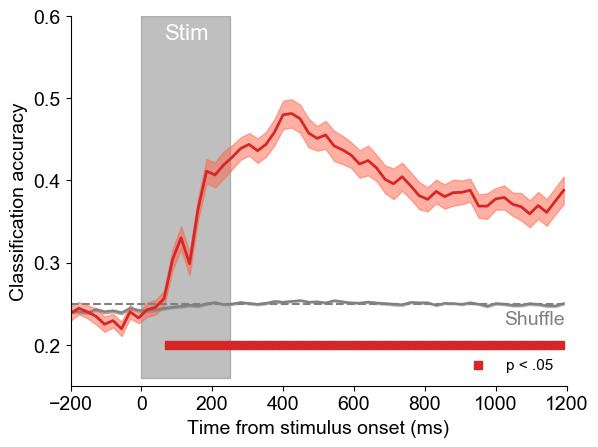

Significant timepoints: [  88  112  136  160  184  208  232  256  280  304  328  352  376  400
  424  448  472  496  520  544  568  592  616  640  664  688  712  736
  760  784  808  832  856  880  904  928  952  976 1000 1024 1048 1072
 1096 1120 1144 1168 1192]
Mean delay accuracy: 0.4095879310966811
Mean delay S.D.: 0.03604939706301303


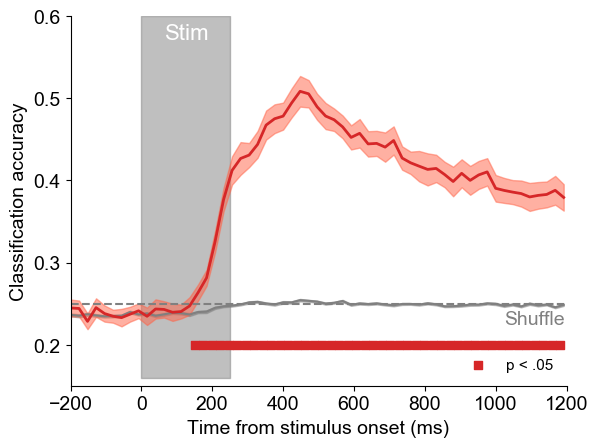

Significant timepoints: [ 160  184  208  232  256  280  304  328  352  376  400  424  448  472
  496  520  544  568  592  616  640  664  688  712  736  760  784  808
  832  856  880  904  928  952  976 1000 1024 1048 1072 1096 1120 1144
 1168 1192]
Mean delay accuracy: 0.4305450720046083
Mean delay S.D.: 0.03768291058524734


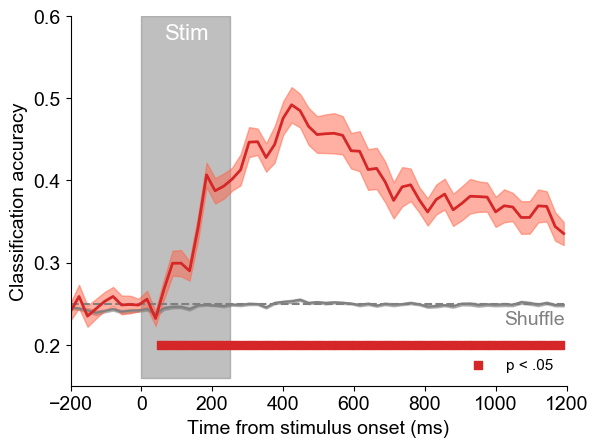

Significant timepoints: [  64   88  112  136  160  184  208  232  256  280  304  328  352  376
  400  424  448  472  496  520  544  568  592  616  640  664  688  712
  736  760  784  808  832  856  880  904  928  952  976 1000 1024 1048
 1072 1096 1120 1144 1168 1192]
Mean delay accuracy: 0.40454437500000007
Mean delay S.D.: 0.042239991679204184


In [20]:
experiment_names = ['1801','1901','1902']
for experiment_name in experiment_names:
    results_pickle = f'{experiment_name}_trialbin20.pickle'

    # Set up interp object and load results.
    interp = decode_eeg.Interpreter()
    interp.load_results(results_pickle)

    interp.plot_acc(significance_testing=True,ylim=[.15,.6],chance_text_y=.205,subtitle=f'{experiment_name}_',savefig=False)